In [1]:
import requests
import time
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
agenskalns = "https://www.ss.lv/lv/real-estate/flats/riga/agenskalns/sell/"

In [3]:
req = requests.get(agenskalns)
req.text[:200]


'<!DOCTYPE html>\r\n<HTML><HEAD>\r\n<title>SS.LV Dzīvokļi - Rīga - Āgenskalns, Cenas, Pārdod - Sludinājumi</title>\r\n<meta http-equiv="Content-Type" CONTENT="text/html; charset=UTF-8">\r\n<meta name="viewport'

In [4]:
soup = BeautifulSoup(req.text, 'lxml')


In [5]:
def getColList(soup):
    column_list = ["description","url"] # we decided to that we need these two column names no matter the html
    headline = soup.find("tr", {"id":"head_line"})
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]] # this will get all column names starting with 2nd in HTML
    column_list += headcolumns
    return column_list

In [6]:
column_names = getColList(soup)
column_names

['description',
 'url',
 'Iela',
 'Ist.',
 'm2',
 'Stāvs',
 'Sērija',
 'Cena, m2',
 'Cena']

In [7]:
trows = soup.find_all('tr')

def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

In [8]:
def getRow(row,colist=column_names):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) <3: # a little sanity check
        print("Hmm bad row")
        return rowDict
    
    rowDict[colist[0]] = row_tds[2].text # so the big assumption is that we always get description in 3rd column
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

In [9]:
def getRows(rowlist,colist=column_names):
    return [getRow(row, colist=colist) for row in rowlist]

In [10]:
def getDFfromURL(url):
    # print("getting data from", url)
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None # maybe return empty dataframe here
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows, columns=column_names)

In [11]:
df = getDFfromURL(agenskalns)

df.head()

,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena
0,Hepsor jaunajā projektā Sentimento tiek pārdot...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Āgenskalna 24,2,41,1/5,Jaun.,"2,046 €","83,900 €"
1,Hepsor jaunajā projektā Sentimento tiek pārdot...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Āgenskalna 24,2,33,1/5,Jaun.,"2,118 €","69,900 €"
2,Īpašnieks pārdod 2-istabu dzīvokli (32 m2) ar ...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Spāres 6,2,32,2/2,P. kara,688 €,"22,000 €"
3,Āgenskalna vēsturiskajā centrā – Mazā Nometņu ...,https://ss.com/msg/lv/real-estate/flats/riga/a...,M. Nometņu 17 A,2,42,2/3,Renov.,"2,036 €","85,500 €"
4,Kapitāli remontēts un pārplānots divstabu dzīv...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Ernestīnes 26,2,45,2/3,Hrušč.,"1,511 €","68,000 €"


In [12]:
anchors = soup.find_all("a")

navs = [anchor for anchor in anchors if anchor.get("name") == "nav_id"] # get will get us None if no "name" exists
len(navs)

# could use regular expression here but we can use split 
afterpage = navs[0]['href'].split("/page")[-1] # -1 might be safer than 1 in case there is region with name page

beforedot = afterpage.split(".html")[0]

lastpage = int(beforedot)
lastpage


4

In [13]:
def getAllLocalUrls(url):
    """Get a list of all urls including paginated pages"""
    results = [url] # default is just the url if no extra pages found
    req = requests.get(url)
    if req.status_code != 200:
        print(f"Bad response! {req.status_code}")
        return []
    soup = BeautifulSoup(req.text, 'lxml')
    # we just need a one element
    prevanchor = soup.find('a', {"rel":"prev"})
    if prevanchor == None: # means there is only one page of ads
        return results
    href = prevanchor.attrs.get('href')
    lastPageNum = int(href.split('/page')[-1].split('.html')[0])
    print("Last page is",lastPageNum)
    nurls = [f"{url}page{n}.html" for n in range(2,lastPageNum+1)]
    results += nurls
    return results

In [14]:
local_urls = getAllLocalUrls(agenskalns)
len(local_urls),local_urls[:3],local_urls[-1]

Last page is 4


(4,
 ['https://www.ss.lv/lv/real-estate/flats/riga/agenskalns/sell/',
  'https://www.ss.lv/lv/real-estate/flats/riga/agenskalns/sell/page2.html',
  'https://www.ss.lv/lv/real-estate/flats/riga/agenskalns/sell/page3.html'],
 'https://www.ss.lv/lv/real-estate/flats/riga/agenskalns/sell/page4.html')

In [15]:
dlast = getDFfromURL(local_urls[-1])
dlast.shape

(17, 9)

In [16]:
def get_all_ads_df(start_url, save_excel_path=None):
    df_list=[] # so we will save our dataframes in a list
    local_urls = getAllLocalUrls(start_url)
    for url in local_urls:
        print(f"Gathering data from {url}")
        df_list.append(getDFfromURL(url))
        time.sleep(0.3) # we need this to play nice!
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
    big_df = pd.concat(df_list) # then make a big dataframe from all the small dataframes
    if save_excel_path:
        big_df.to_excel(save_excel_path)
    return big_df



In [17]:
df = get_all_ads_df(agenskalns, "agenskalns_28_01.xlsx")

Last page is 4
Gathering data from https://www.ss.lv/lv/real-estate/flats/riga/agenskalns/sell/
Gathering data from https://www.ss.lv/lv/real-estate/flats/riga/agenskalns/sell/page2.html
Gathering data from https://www.ss.lv/lv/real-estate/flats/riga/agenskalns/sell/page3.html
Gathering data from https://www.ss.lv/lv/real-estate/flats/riga/agenskalns/sell/page4.html


In [18]:
#we can do more post processing - feature engineering using existing columns
df[['Floor','MaxFloor']] = df.Stāvs.str.split("/",expand=True) 
df.head()

,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena,Floor,MaxFloor
0,Hepsor jaunajā projektā Sentimento tiek pārdot...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Āgenskalna 24,2,41,1/5,Jaun.,"2,046 €","83,900 €",1,5
1,Hepsor jaunajā projektā Sentimento tiek pārdot...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Āgenskalna 24,2,33,1/5,Jaun.,"2,118 €","69,900 €",1,5
2,Īpašnieks pārdod 2-istabu dzīvokli (32 m2) ar ...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Spāres 6,2,32,2/2,P. kara,688 €,"22,000 €",2,2
3,Āgenskalna vēsturiskajā centrā – Mazā Nometņu ...,https://ss.com/msg/lv/real-estate/flats/riga/a...,M. Nometņu 17 A,2,42,2/3,Renov.,"2,036 €","85,500 €",2,3
4,Kapitāli remontēts un pārplānots divstabu dzīv...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Ernestīnes 26,2,45,2/3,Hrušč.,"1,511 €","68,000 €",2,3


In [19]:
df.sort_values(by="Floor",ascending=False).head()

,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena,Floor,MaxFloor
7,Īpašums ar diviem funkcionāli nodalītiem augst...,https://ss.com/msg/lv/real-estate/flats/riga/a...,M. Nometņu 1,6,218,7/8,Specpr.,"1,239 €","270,000 €",7,8
28,Апартаменты в башнях Philosophers c панорамным...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Raņķa d. 34,3,91,6/23,Jaun.,"2,345 €","213,400 €",6,23
17,Jauna un laba cena - Īpašnieks pārdod skaistu ...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Raņķa d. 9,3,115,6/6,Renov.,"1,470 €","169,000 €",6,6
20,"Продается просторная, полностью мебелированная...",https://ss.com/msg/lv/real-estate/flats/riga/a...,Kalnciema 46,3,93,6/6,P. kara,"1,462 €","136,000 €",6,6
25,Собственник продает комфортабельную квартиру с...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Daugavgrīvas 60,2,60,6/7,Specpr.,"1,083 €","65,000 €",6,7


In [20]:
# 1b
apt = df['Floor'].sort_values(ascending=False).max()
print("Highest available floor: ", apt)


Highest available floor:  7


In [21]:
# 1c
df["price"] = df.Cena.str.split(' ').str[0]
df.head()

,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena,Floor,MaxFloor,price
0,Hepsor jaunajā projektā Sentimento tiek pārdot...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Āgenskalna 24,2,41,1/5,Jaun.,"2,046 €","83,900 €",1,5,"83,900"
1,Hepsor jaunajā projektā Sentimento tiek pārdot...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Āgenskalna 24,2,33,1/5,Jaun.,"2,118 €","69,900 €",1,5,"69,900"
2,Īpašnieks pārdod 2-istabu dzīvokli (32 m2) ar ...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Spāres 6,2,32,2/2,P. kara,688 €,"22,000 €",2,2,"22,000"
3,Āgenskalna vēsturiskajā centrā – Mazā Nometņu ...,https://ss.com/msg/lv/real-estate/flats/riga/a...,M. Nometņu 17 A,2,42,2/3,Renov.,"2,036 €","85,500 €",2,3,"85,500"
4,Kapitāli remontēts un pārplānots divstabu dzīv...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Ernestīnes 26,2,45,2/3,Hrušč.,"1,511 €","68,000 €",2,3,"68,000"


In [22]:
df.price = df.price.str.replace(",","").astype('int32')
df.head()

,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena,Floor,MaxFloor,price
0,Hepsor jaunajā projektā Sentimento tiek pārdot...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Āgenskalna 24,2,41,1/5,Jaun.,"2,046 €","83,900 €",1,5,83900
1,Hepsor jaunajā projektā Sentimento tiek pārdot...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Āgenskalna 24,2,33,1/5,Jaun.,"2,118 €","69,900 €",1,5,69900
2,Īpašnieks pārdod 2-istabu dzīvokli (32 m2) ar ...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Spāres 6,2,32,2/2,P. kara,688 €,"22,000 €",2,2,22000
3,Āgenskalna vēsturiskajā centrā – Mazā Nometņu ...,https://ss.com/msg/lv/real-estate/flats/riga/a...,M. Nometņu 17 A,2,42,2/3,Renov.,"2,036 €","85,500 €",2,3,85500
4,Kapitāli remontēts un pārplānots divstabu dzīv...,https://ss.com/msg/lv/real-estate/flats/riga/a...,Ernestīnes 26,2,45,2/3,Hrušč.,"1,511 €","68,000 €",2,3,68000


In [24]:
# 1b
df.to_excel("C:/temp/my_apartments.xlsx")

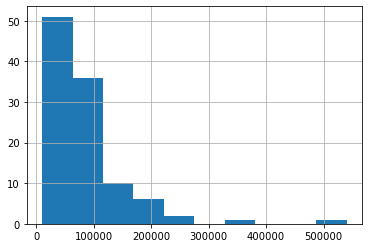

In [25]:
df.price.hist()

In [26]:
df.groupby(by="Sērija").agg({"price":"mean"})

,price
Sērija,
103.,60000.000000
467.,44000.000000
Hrušč.,56531.250000
Jaun.,196606.153846
LT proj.,60166.666667
P. kara,54579.428571
Priv. m.,113833.333333
Renov.,92434.350000
Specpr.,71419.916667
